In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

%matplotlib inline

# loading and viewing data


In [2]:
import tarfile
fname = "fer2013.tar.gz"
if (fname.endswith("tar.gz")):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()
elif (fname.endswith("tar")):
    tar = tarfile.open(fname, "r:")
    tar.extractall()
    tar.close()

In [3]:
dataset = "fer2013/fer2013.csv"
data = pd.read_csv(dataset)
# data['pixels'] = np.array(data['pixels'].rstrip().split(' ')).astype(int)
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
# emotion labels from FER2013:
emotion = {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3,
           'Sad': 4, 'Surprise': 5, 'Neutral': 6}
emo     = ['Angry', 'Fear', 'Happy',
           'Sad', 'Surprise', 'Neutral']
print(data.Usage.value_counts())
print("\n")
print("LABELS:"+"\n")
print(emotion)
print(data.emotion.value_counts())


Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64


LABELS:

{'Sad': 4, 'Surprise': 5, 'Disgust': 1, 'Neutral': 6, 'Fear': 2, 'Angry': 0, 'Happy': 3}
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64


In [5]:
def show_data(start, end, data):
    fig = plt.figure(figsize=(8,10))
    for i in range(start, end+1):
        _img = data['pixels'][i]
        _img = np.array(_img.rstrip().split(' ')).astype(int)
        _img = np.reshape(_img, (48,48))
        ax = fig.add_subplot(16,12,i+1)
        ax.imshow(_img, cmap="gray")
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
    plt.show()

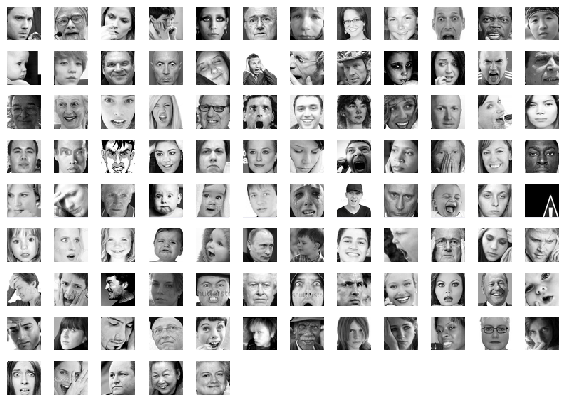

In [6]:
show_data(0,100, data)

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


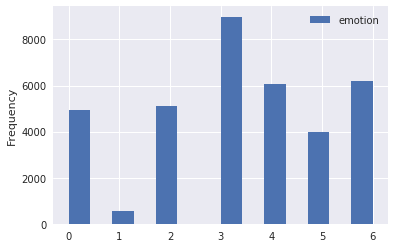

In [7]:
# sns.set_context('poster')
data.plot(x='Usage', y='emotion', kind='hist', bins=14)

In [8]:
def one_hot_encode(x):
    
#     encoded_x = one_hot_encoder.transform(x)
    return np.eye(7)[x]

In [9]:
features = np.array(data['pixels'])
labels = np.array(data['emotion'])
print(features.shape)
limit = 35887
featurez = np.zeros((limit,48,48,1))
one_hot_labels = np.zeros((limit,7))
for i in range(limit):
    features[i] =  np.array(features[i].rstrip().split(' ')).astype(float)
    featurez[i] = np.reshape(features[i], [48,48,1])
    one_hot_labels[i] = one_hot_encode(labels[i])
# print(featurez[0],"\n", labels[0])

(35887,)


In [10]:
assert all(x.shape == (48,48,1) for x in featurez)

In [11]:
print(features.shape, labels.shape,type(features[0]), type(labels[0]), labels[0:6])

(35887,) (35887,) <class 'numpy.ndarray'> <class 'numpy.int64'> [0 0 2 4 6 2]


In [12]:
features[0].shape

(2304,)

In [13]:
one_hot_encode(labels[0])

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.])

In [14]:
assert all(x.shape == (7,) for x in one_hot_labels)

In [15]:
# len(features[0:5000])

# splitting into test sets and training sets


In [16]:
# [float(feature) for feature in features[0].split()] 
split_idx=0.9
n_records = limit
split = int(split_idx*n_records) #*n_records

# trainX, trainY = features[:split],features[split:]
# testX, testY = labels[:split], labels[split:]


trainX, testX = featurez[:split],featurez[split:]
np.reshape(trainX, [split,48,48,1])
np.reshape(testX,[(limit-split),48,48,1])
trainY, testY = one_hot_labels[:split], one_hot_labels[split:]
# np.reshape(trainY, [500,48,48])

In [17]:
print(trainX.shape, trainY.shape)

(32298, 48, 48, 1) (32298, 7)


In [18]:
print(testX.shape, testY.shape)

(3589, 48, 48, 1) (3589, 7)


In [19]:
type(trainY)

numpy.ndarray

# Model

In [20]:
def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    with tf.name_scope('input_image'):
        input_image = tf.placeholder(tf.float32,
                                     shape = [None, image_shape[0],image_shape[1], image_shape[2]],
                                     name = 'x')
#     reshaped_input_image = tf.reshape(input_image,[1,image_shape[0],image_shape[1],1], name = 'reshaped_x')
    
        return input_image
                
def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    with tf.name_scope('one_hot_output_labels'):
        input_labels = tf.placeholder(tf.float32, shape= [None, n_classes], name = 'y')
        return input_labels


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    
    dropout_prob = tf.placeholder(tf.float32, name = 'keep_prob')
    return dropout_prob

### Convoultional layers

In [21]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    
    n_filters = conv_num_outputs
    
    color_channels = int(x_tensor.shape[3])
    
    #initialising weights and biases
    weight = tf.Variable(tf.truncated_normal(shape=[*conv_ksize, color_channels, n_filters], stddev=0.1))
    bias = tf.Variable(tf.zeros(n_filters))

    conv_layer = tf.nn.conv2d(x_tensor, weight, strides=[1, *conv_strides, 1], padding='SAME')
    conv_layer = tf.nn.bias_add(conv_layer, bias)
    conv_layer = tf.nn.relu(conv_layer)
    
    conv_layer = tf.nn.max_pool(conv_layer, 
                               ksize=[1, *pool_ksize, 1],
                               strides=[1, *pool_strides, 1],
                                padding = 'SAME')
    
    return conv_layer 

# flatten layer

In [22]:
def flatten(x_tensor):
    
    input_shape = x_tensor.shape.as_list()
#     print(input_shape)
    flattened_image_shape = np.prod(input_shape[1:])
    flat_x = tf.reshape(x_tensor, shape=[-1, flattened_image_shape])
    return flat_x

# fully connected

In [23]:
def fully_conn(x_tensor, num_outputs):
    
    n_inputs = x_tensor.shape.as_list()[1]
    
    weights = tf.Variable(tf.truncated_normal([n_inputs, num_outputs], stddev=0.1))
    biases = tf.Variable(tf.zeros(num_outputs))
    
    layer = tf.nn.bias_add(tf.matmul(x_tensor, weights),biases)
    layer = tf.nn.relu(layer)
    return layer

# output layer

In [24]:
def output(x_tensor, num_outputs):
    
    n_inputs = x_tensor.shape.as_list()[1]
    
    weights = tf.Variable(tf.truncated_normal([n_inputs, num_outputs], stddev = 0.1))
    biases = tf.Variable(tf.zeros(num_outputs))
    
    layer = tf.nn.bias_add(tf.matmul(x_tensor, weights),biases)

    return layer

# DEfining model

In [25]:
def conv_net(x, keep_prob):
   
    with tf.name_scope('convolutional_layers'):
        # x is 32x32x3 48x48x1

        x = conv2d_maxpool(x, 32, (3,3), (1,1), (2,2), (2,2))
#         x = tf.nn.dropout(x, keep_prob)

        #x is 16x16x64 24x24x32
        x = conv2d_maxpool(x, 64, (3,3), (1,1), (2,2), (2,2))
#         x = tf.nn.dropout(x, keep_prob)

        #x is 8x8x128  12x12x64
        x = conv2d_maxpool(x, 128, (3,3), (1,1), (2,2), (2,2))
#         x = tf.nn.dropout(x, keep_prob)
    
    #x is 4x4x256   6x6x128
    
    x = flatten(x)
    
    # x is [None, 4096]  [None,4608]
    
#     x = fully_conn(x, 2043)
#     x = tf.nn.dropout(x, keep_prob)
    with tf.name_scope('fully_connected_dense_layers'):
        x = fully_conn(x, 512)
        x = tf.nn.dropout(x, keep_prob)

        x = fully_conn(x, 50)
        x = tf.nn.dropout(x, keep_prob)
        
    with tf.name_scope('logit_output'):
        out = output(x, 7)

   
    return out

In [26]:
# the network
tf.reset_default_graph()
learning_rate = 0.0001
# Inputs
x = neural_net_image_input((48, 48,1))
y = neural_net_label_input(7)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)
prediction = tf.nn.softmax(logits)

# logits Tensor, so that it can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y), name='cost')
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

# training network and printing stats

In [32]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
   
    session.run(optimizer, feed_dict ={
        x: feature_batch,
        y: label_batch,
        keep_prob: keep_probability
    })
    
def print_stats(session, feature_batch, label_batch, cost, accuracy):
   
   
    global testX, testY
    
    loss = session.run(cost, feed_dict={
        x: feature_batch,
        y: label_batch,
        keep_prob: 1.0
    })
    
    validation_accuracy = session.run(accuracy, feed_dict={
        x: testX,
        y:testY,
        keep_prob: 1.0
    })
    
    
    print('Loss: {:.4f} '.format(loss))

In [33]:
# hyperparameters
epochs = 100
batch_size = 128
keep_probability = 0.5
# split_idx = 0.9
model_path = "/tmp/model.ckpt"

# Training

In [34]:

print('Checking the Training on a Single Batch...')

init = tf.global_variables_initializer()
with tf.Session() as sess:
    # Initializing the variables
    sess.run(init)
    saver = tf.train.Saver()
    #tensorboard
    file_writer = tf.summary.FileWriter('./logs/1', sess.graph)
    # Training cycle
    batch_i = 0
    start = 0
    for epoch in range(epochs):
        
        batch_x = trainX[start:start+batch_size]
        batch_y = trainY[start:start+batch_size]
        
        train_neural_network(sess, optimizer, keep_probability, batch_x, batch_y)
#         sess.run(optimizer, feed_dict={x:trainX,y:trainY, keep_prob:0.5})
        print('Epoch {:>2}, Faces Batch {}:  '.format(epoch + 1, batch_i), end='')
#         train_writer.add_summary(summary, epoch+1)
        print_stats(sess, batch_x, batch_y, cost, accuracy)
        batch_i +=1
        start += batch_size
        
    save_path = saver.save(sess, model_path)
    print("Model saved in file: %s" % save_path)  

Checking the Training on a Single Batch...
Epoch  1, Faces Batch 0:  Loss: 312.3597 
Epoch  2, Faces Batch 1:  Loss: 224.9359 
Epoch  3, Faces Batch 2:  Loss: 151.5229 
Epoch  4, Faces Batch 3:  Loss: 101.7088 
Epoch  5, Faces Batch 4:  Loss: 80.2659 
Epoch  6, Faces Batch 5:  Loss: 63.1226 
Epoch  7, Faces Batch 6:  Loss: 65.1829 
Epoch  8, Faces Batch 7:  Loss: 61.6597 
Epoch  9, Faces Batch 8:  Loss: 51.7594 
Epoch 10, Faces Batch 9:  Loss: 69.4698 
Epoch 11, Faces Batch 10:  Loss: 61.5167 
Epoch 12, Faces Batch 11:  Loss: 61.7393 
Epoch 13, Faces Batch 12:  Loss: 52.3324 
Epoch 14, Faces Batch 13:  Loss: 43.2688 
Epoch 15, Faces Batch 14:  Loss: 47.0284 
Epoch 16, Faces Batch 15:  Loss: 40.7738 
Epoch 17, Faces Batch 16:  Loss: 42.9936 
Epoch 18, Faces Batch 17:  Loss: 33.9464 
Epoch 19, Faces Batch 18:  Loss: 28.8932 
Epoch 20, Faces Batch 19:  Loss: 25.1109 
Epoch 21, Faces Batch 20:  Loss: 19.5611 
Epoch 22, Faces Batch 21:  Loss: 18.2891 
Epoch 23, Faces Batch 22:  Loss: 14.498

In [38]:
# print("Starting 2nd session...")
# with tf.Session() as sess:
#     # Initialize variables
#     init = tf.global_variables_initializer()
#     sess.run(init)
#     saver = tf.train.Saver()
#     # Restore model weights from previously saved model
#     saver.restore(sess, model_path)
#     print("Model restored from file: %s" % save_path)
#     pred=sess.run(prediction, feed_dict={x:testX, keep_prob:1})
#     accu = sess.run(accuracy, feed_dict={
#         x: testX,
#         y:testY,
#         keep_prob: 1.0
#     })

In [39]:
# print(accu)

In [40]:
testY[5]

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.])

In [41]:
import cv2

ImportError: libgtk-x11-2.0.so.0: cannot open shared object file: No such file or directory

In [ ]:
# Running a new session
print("Starting 2nd session...")
with tf.Session() as sess:
    # Initialize variables
    init = tf.global_variables_initializer()
    sess.run(init)
    saver = tf.train.Saver()
    # Restore model weights from previously saved model
    saver.restore(sess, model_path)
    print("Model restored from file: %s" % save_path)
    
    faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    noseCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

    cap = cv2.VideoCapture(0)

    # cv2.namedWindow("crop", cv2.WINDOW_NORMAL)

    z = 7 #zoom factor (lower value is higher zoom)

    while True:
        ret, img = cap.read()

        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY,1)
        faces = faceCascade.detectMultiScale(
            img_gray,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(30, 30),
            flags=cv2.CASCADE_SCALE_IMAGE
            # flags=cv2.cv.CV_HAAR_SCALE_IMAGE
        )

        emotion_name = ["anger", "disgust", "fear", "happy", "sad", "surprise", "neutral", "unknown"]
        
        for (x,y,w,h) in faces:
            down_offset = int(h/14)
            cv2.rectangle(img,(x+w//z,y+h//z +down_offset),(x+w-w//z,y+h-h//z +down_offset),(255,0,0),2)
            roi_gray = img_gray[y+h//z:y+h-h//z, x+w//z:x+w-w//z]
            #print(type(roi_gray))
            cv2.imshow("faces", cv2.resize(roi_gray, (48*2, 48*2), interpolation=cv2.INTER_AREA))
            pixel_array = cv2.resize(roi_gray, (48, 48), interpolation=cv2.INTER_AREA)
            print(pixel_array.shape, type(pixel_array))
            
            pixel_array = np.resize(pixel_array,[1,48,48,1])
            value = sess.run(prediction, feed_dict={x: pixel_array})
            print(value)
            correct_emotion = emotion_name[np.argmax(value[0])]

        cv2.imshow('img',img)
        k = cv2.waitKey(30) & 0xff
        if k == 27:
            break

    cap.release()
    cv2.destroyAllWindows()

In [1]:
import numpy as np





KeyboardInterrupt: 